In [1]:
from autograd import grad
from autograd import numpy as npa
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

In [26]:
def test_kwargs(a,b=3,c=10):
    return a**2*(b**4+c/4)
gwkarg = grad(test_kwargs,0)
a = 2.0
print(gwkarg(a,b=4,c=10))

1034.0


(768, 1024)
(768, 1024)
28.719311719914675


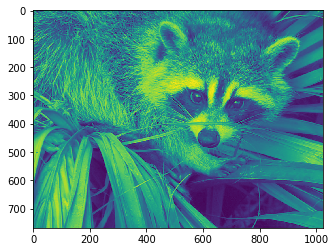

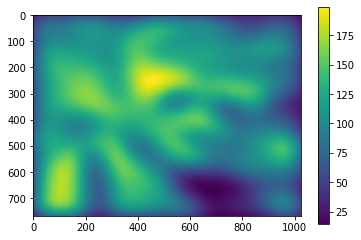

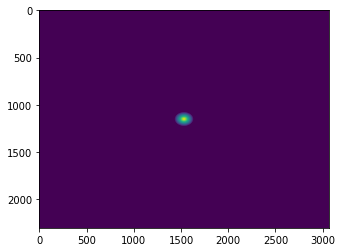

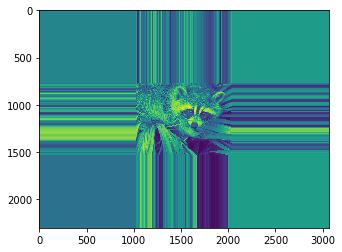

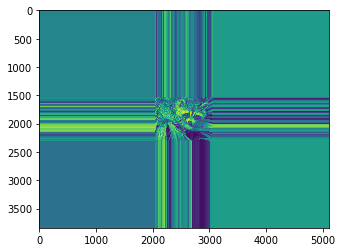

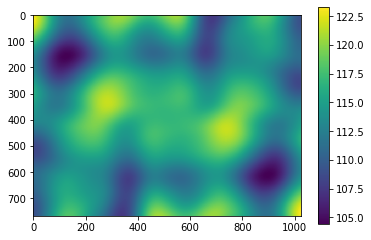

In [35]:
def rectangle_mask(x,y,width,height,centerx,centery):
    return (np.abs(x - centerx) <= width/2) & (np.abs(y - centery) <= height/2)
def border_mask(x,y,width,height,radius):
    a = (width - 2*radius) / 2
    b = (height - 2*radius) / 2
    return (np.maximum(np.abs(x)-a,np.zeros(x.shape)) ** 2 + 
            np.maximum(np.abs(y)-b,np.zeros(y.shape)) ** 2 <= radius ** 2)

def _edge_pad(arr, pad):
    # fill sides
    left = npa.tile(arr[0,:],(pad[0][0],1)) # left side
    right = npa.tile(arr[-1,:],(pad[0][1],1)) # right side
    top = npa.tile(arr[:,0],(pad[1][0],1)).transpose() # top side
    bottom = npa.tile(arr[:,-1],(pad[1][1],1)).transpose() # bottom side)
    
    # fill corners
    top_left = npa.tile(arr[0,0], (pad[0][0],pad[1][0])) # top left
    top_right = npa.tile(arr[-1,0], (pad[0][1],pad[1][0])) # top right
    bottom_left = npa.tile(arr[0,-1], (pad[0][0],pad[1][1])) # bottom left
    bottom_right = npa.tile(arr[-1,-1], (pad[0][1],pad[1][1])) # bottom right
    
    out = npa.concatenate((
        npa.concatenate((top_left,top,top_right)),
        npa.concatenate((left,arr,right)),
        npa.concatenate((bottom_left,bottom,bottom_right))    
    ),axis=1)
    
    return out

def _zero_pad(arr, pad):
    # fill sides
    left = npa.tile(0,(pad[0][0],arr.shape[1])) # left side
    right = npa.tile(0,(pad[0][1],arr.shape[1])) # right side
    top = npa.tile(0,(arr.shape[0],pad[1][0])) # top side
    bottom = npa.tile(0,(arr.shape[0],pad[1][1])) # bottom side
    
    # fill corners
    top_left = npa.tile(0, (pad[0][0],pad[1][0])) # top left
    top_right = npa.tile(0, (pad[0][1],pad[1][0])) # top right
    bottom_left = npa.tile(0, (pad[0][0],pad[1][1])) # bottom left
    bottom_right = npa.tile(0, (pad[0][1],pad[1][1])) # bottom right
    
    out = npa.concatenate((
        npa.concatenate((top_left,top,top_right)),
        npa.concatenate((left,arr,right)),
        npa.concatenate((bottom_left,bottom,bottom_right))    
    ),axis=1)
    
    return out

def _centered(arr, newshape):
    # Return the center newshape portion of the array.
    newshape = np.asarray(newshape)
    currshape = np.array(arr.shape)
    startind = (currshape - newshape) // 2
    endind = startind + newshape
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

def simple_2d_filter(x,kernel):
    if (x.shape[0] != kernel.shape[0]) or (x.shape[1] != kernel.shape[1]):
        raise ValueError("The input {} and kernel {} must have the same shape.".format(x.shape,kernel.shape))
    Nx, Ny = kernel.shape
    
    # pad the kernel and input to avoid circular convolution garbage
    kernel = _zero_pad(kernel,((Nx,Nx),(Ny,Ny)))
    x = _edge_pad(x,((Nx,Nx),(Ny,Ny)))
    plt.figure()
    plt.imshow(kernel)
    plt.figure()
    plt.imshow(x)
    plt.figure()
    plt.imshow(np.pad(x, ((Nx,Nx),(Ny,Ny)), 'edge'))
    H = npa.fft.fft2(kernel)
    X = npa.fft.fft2(x)
    Y = H * npa.conjugate(X) * X / npa.abs(X)
    
    # We need to fftshift since we padded both sides if each dimension of our input and kernel.
    y = npa.fft.fftshift(npa.real(npa.fft.ifft2(Y)))
    return _centered(y,(Nx,Ny))

def gaussian_filter(x,sigma,Lx,Ly,resolution):
    # lazy import
    from scipy import special, signal
    
    sigma=sigma*resolution
    
    Nx = int(Lx*resolution)
    Ny = int(Ly*resolution)
    
    # Top hat filter kernel
    kernel = np.outer(signal.gaussian(Nx, sigma), signal.gaussian(Ny, sigma)) # Gaussian filter kernel
    kernel = kernel / np.sum(kernel.flatten()) # Normalize the filter
        
    return simple_2d_filter(x.reshape(Nx,Ny),kernel)
def conic_filter(x,radius,Lx,Ly,resolution):
    Nx = int(Lx*resolution)
    Ny = int(Ly*resolution)
    
    xv, yv = np.meshgrid(np.linspace(-Lx/2,Lx/2,Nx), np.linspace(-Ly/2,Ly/2,Ny), sparse=True)
    kernel = np.where(np.abs(xv ** 2 + yv ** 2) <= radius**2,(1-np.sqrt(abs(xv ** 2 + yv ** 2))/radius),0)
    kernel = kernel / np.sum(kernel.flatten()) # Normalize the filter
    return simple_2d_filter(x.reshape(Nx,Ny),kernel)

def tanh_projection(x,beta,eta):
    return (npa.tanh(beta*eta) + npa.tanh(beta*(x-eta))) / (npa.tanh(beta*eta) + npa.tanh(beta*(1-eta)))

from scipy import misc
from scipy import signal
face = misc.face(gray=True)
shape = face.shape
plt.figure()
plt.imshow(face)

# -------------------------------------------------------- #
Nx = shape[1]
Ny = shape[0]
Lx = 1
Ly = 1
radius = 0.1

xv, yv = np.meshgrid(np.linspace(-Lx/2,Lx/2,Nx), np.linspace(-Ly/2,Ly/2,Ny), sparse=True)
kernel = np.where(np.abs(xv ** 2 + yv ** 2) <= radius**2,(1-np.sqrt(abs(xv ** 2 + yv ** 2))/radius),0)
kernel = kernel / np.sum(kernel.flatten()) # Normalize the filter
# -------------------------------------------------------- #
sci_bl = signal.fftconvolve(face, kernel, mode='same')
plt.figure()
a = plt.imshow(sci_bl)
plt.colorbar(a)
# -------------------------------------------------------- #
print(face.shape)
print(kernel.shape)
my_bl = simple_2d_filter(face, kernel)
plt.figure()
a = plt.imshow(my_bl)
plt.colorbar(a)
err = np.mean(np.abs(my_bl.flatten() - sci_bl.flatten()))
print(err)

0.1716000000000047
[[0.01907411 0.00935985 0.0104785  ... 0.00935985 0.00766322 0.01141088]
 [0.00935985 0.00445462 0.00500537 ... 0.00445462 0.00365981 0.00570004]
 [0.0104785  0.00500537 0.00562737 ... 0.00500537 0.00410807 0.00637043]
 ...
 [0.00935985 0.00445462 0.00500537 ... 0.00445462 0.00365981 0.00570004]
 [0.00766322 0.00365981 0.00410807 ... 0.00365981 0.00300749 0.00465574]
 [0.01141088 0.00570004 0.00637043 ... 0.00570004 0.00465574 0.00675515]]


"plt.figure()\nplt.plot(dg,y.flatten()[idx],'o')"

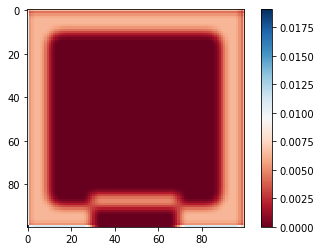

In [8]:
Lx = 1
Ly = 1
resolution = 100
radius = 0.05
x = 1*np.ones(resolution*resolution,)


y = conic_filter(x,radius,Lx,Ly,resolution)

xx, yy = np.meshgrid(np.linspace(-0.5,0.5,resolution),np.linspace(-0.5,0.5,resolution),sparse=True)
mask = border_mask(xx,yy,0.8,0.8,radius)
mask_rec = rectangle_mask(xx,yy,0.4,0.4,
                              -0.25-0.4+0.1,0)
mask = ~(mask ^ mask_rec)
x2 = 0.5*np.ones(resolution*resolution,)
x[mask.flatten()] = 1

def J(x):
    filtered = tanh_projection(conic_filter(x,radius,Lx,Ly,resolution),128,0.5).flatten()
    error = npa.abs(filtered - 0)
    comp = npa.where(mask.flatten(),error,0)
    return npa.mean(comp)
fig = plt.figure()
plt.imshow(np.rot90(mask.reshape(resolution,resolution)),cmap='binary')
print(J(x2))
y = grad(J)(x2).reshape(resolution,resolution)
print(y)

a = plt.imshow(np.rot90(y), cmap='RdBu',alpha=1)
fig.colorbar(a)
num_gradients = 5000
idx = np.random.randint(0,resolution*resolution,num_gradients)
dg = np.zeros((num_gradients,))
dx = 1e-1


'''for ki, k in enumerate(idx):
    x2[k] += dx
    g1 = J(x2)
    x2[k] -= 2*dx
    g0 = J(x2)
    dg[ki] = (g1 - g0) / (2*dx)
print(dg)'''
'''plt.figure()
plt.plot(dg,y.flatten()[idx],'o')'''